## Region Scanning
We can use the framework to scan region data sets as well. One methods is to convert the region data set into a point set by sampling regions based on their weight and then sampling points from these regions based on area. This method is outlined below. 

In [1]:
import shapefile
import pyscan
import matplotlib.pyplot as plt
import csv



def plot_points(ax, pts, c):
    xs = []
    ys = []
    for pt in pts:
        xs.append(pt[0] )
        ys.append(pt[1])
    ax.scatter(xs, ys, color=c, marker='.')

def plot_points_traj(ax, pts, c):
    xs = []
    ys = []
    for pt in pts:
        xs.append(pt[0])
        ys.append(pt[1])
    ax.plot(xs, ys, color=c)
    
def plot_approx(ax, regions, core_set_pts):
    for reg in regions:
        plot_points_traj(ax, reg, "g")
    plot_points(ax, core_set_pts, "b")
    ax.set_axis_off()



We read in the population data for the years 2010 and 2017 from the continental US counties. We want to find a region where the population has changed the most relatively over this time period.

In [2]:
shape = shapefile.Reader("county_shapes/cb_2017_us_county_500k.shp")
population2017 = {}
population2010 = {}

with open("county_population/PEP_2017_PEPANNRES_with_ann.csv", encoding='latin-1') as f:
    reader = csv.DictReader(f)
    headers = next(reader, None)
    for row in reader:
        population2017[row['GEO.id2'][-3:]] = int(row['respop72017'])
        population2010[row['GEO.id2'][-3:]] = int(row['respop72010'])

Then we can load in the shapefile corresponding to the boundaries of all the counties in the US.

In [3]:
regions = []
weights2017 = []
weights2010 = []
for reg in shape.shapeRecords():
    ignore = False
    for p in reg.shape.points:
        # remove counties outside of the continental US
        if not (-124.84 <= p[0] <= -66.9 and 24.396 <= p[1] <= 49.4):
            ignore = True
            break
    if not ignore:
        weights2010.append(population2010[reg.record[1]]) #reg.record[2], reg.record[5])
        weights2017.append(population2017[reg.record[1]]) #reg.record[2], reg.record[5])
        regions.append([pyscan.Point(p[0], p[1], 1.0) for p in reg.shape.points])
        
    
alpha = .02
r_min = .05

Since our data corresponds to spatial regions and we are not sure how the population is actually dispersed within the regions we will just assume a uniform prior for each region and sample accordingly. 

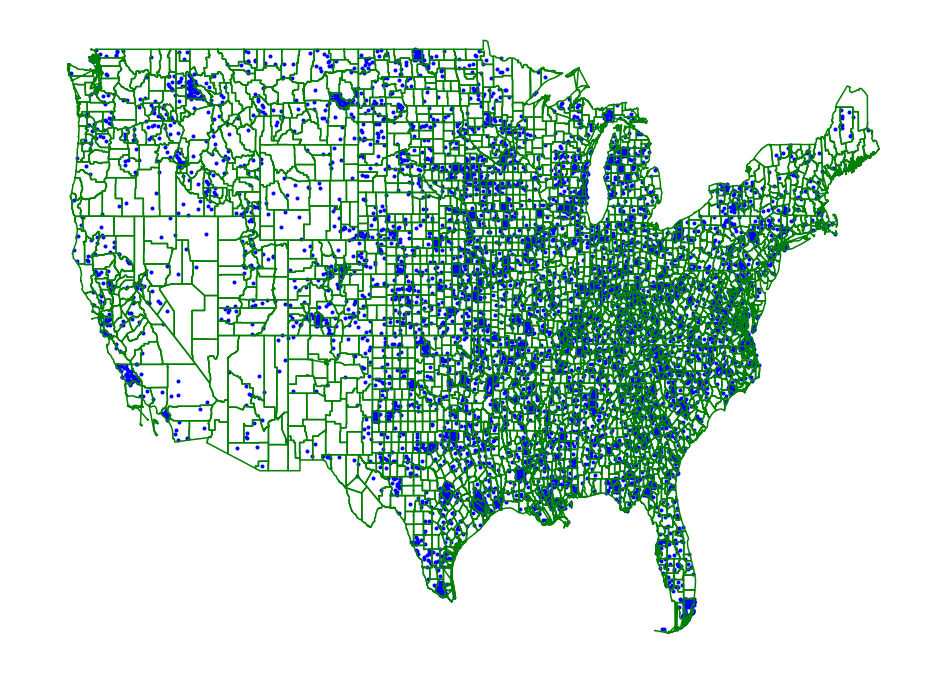

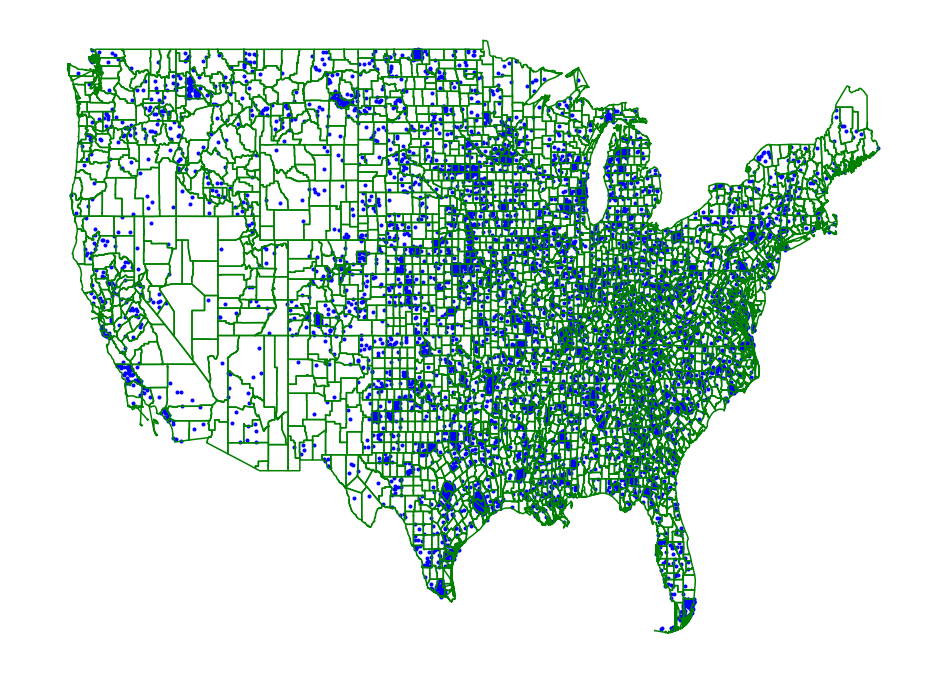

In [4]:
core_set_pts2010 = pyscan.polygon_sample(regions, weights2010, 10000)
f, ax = plt.subplots(figsize=(16, 12))
plot_approx(ax, regions, core_set_pts2010)
plt.show()

core_set_pts2017 = pyscan.polygon_sample(regions, weights2017, 10000)
_, ax = plt.subplots(figsize=(16, 12))
plot_approx(ax, regions, core_set_pts2017)
plt.show()

Now we just run the standard scanning algorithm on this data set to see where they differ. 

In [5]:
net = pyscan.my_sample(core_set_pts2017, 200) + pyscan.my_sample(core_set_pts2010, 200)
disc_f = pyscan.DISC
disk, d_val = pyscan.max_disk(net, 
                              [pyscan.WPoint(1.0, p[0], p[1], 1.0) for p in core_set_pts2017], 
                              [pyscan.WPoint(1.0, p[0], p[1], 1.0) for p in core_set_pts2010], 
                              disc_f)

Plotting the region of interest shows a fairly large section of the middle of the country which is a somewhat useless result.

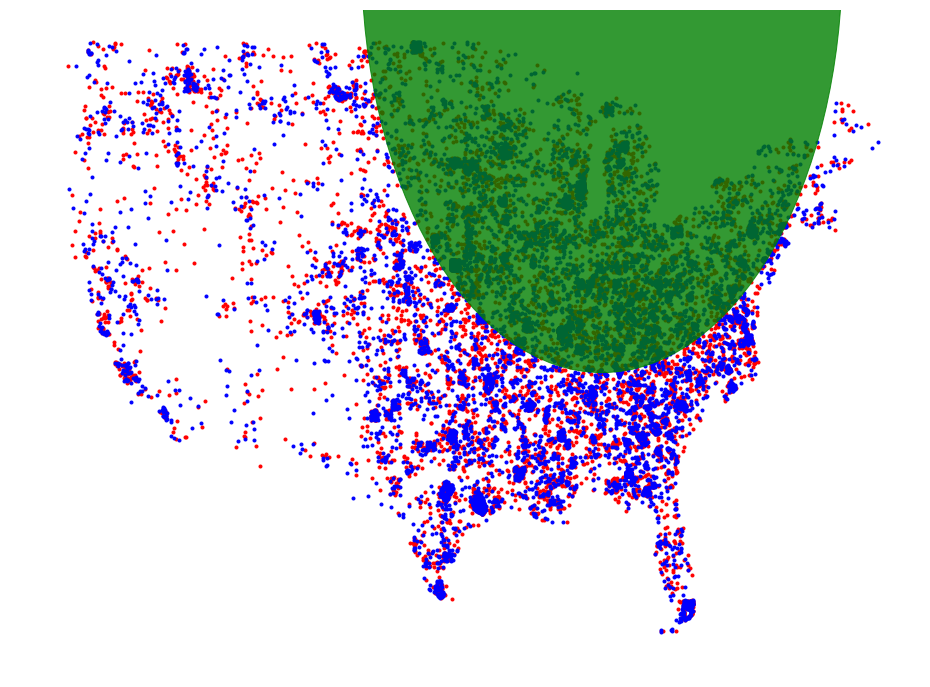

In [6]:
_, ax = plt.subplots(figsize=(16, 12))
plt.axis('off')
plot_points(ax, core_set_pts2010, "r")
plot_points(ax, core_set_pts2017, "b")
d = plt.Circle(disk.get_origin(), disk.get_radius(), color='g', alpha=.8)
ax.add_artist(d)
plt.show()

We can actually restrict the size of the disk to have a maximum radii. This restriction is also used internally by the disk scanning algorithm to speed up the scanning by a potentially significant amount.

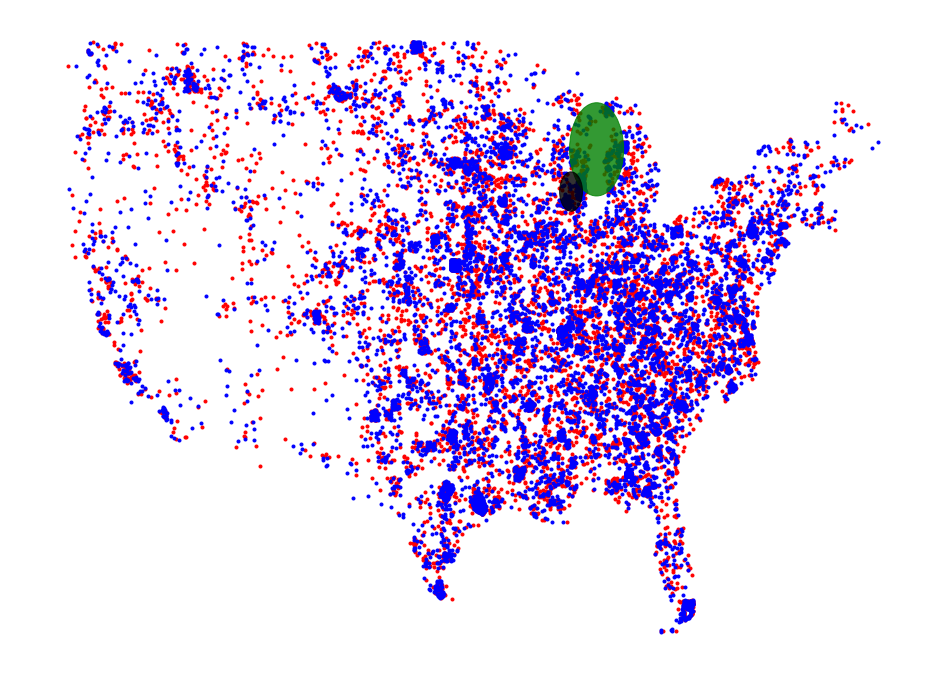

In [10]:
net = pyscan.my_sample(core_set_pts2017, 200) + pyscan.my_sample(core_set_pts2010, 200)
disc_f = pyscan.DISC
disk, d_val = pyscan.max_disk_scale(net, 
                                  [pyscan.WPoint(1.0, p[0], p[1], 1.0) for p in core_set_pts2017], 
                                  [pyscan.WPoint(1.0, p[0], p[1], 1.0) for p in core_set_pts2010],
                                  1,
                                  disc_f)

disk2, d_val = pyscan.max_disk_scale(net, 
                                  [pyscan.WPoint(1.0, p[0], p[1], 1.0) for p in core_set_pts2017], 
                                  [pyscan.WPoint(1.0, p[0], p[1], 1.0) for p in core_set_pts2010],
                                  .5,
                                  disc_f)
_, ax = plt.subplots(figsize=(16, 12))
plt.axis('off')
plot_points(ax, core_set_pts2010, "r")
plot_points(ax, core_set_pts2017, "b")
d = plt.Circle(disk.get_origin(), disk.get_radius(), color='g', alpha=.8)
ax.add_artist(d)
d = plt.Circle(disk2.get_origin(), disk2.get_radius(), color='k', alpha=.8)
ax.add_artist(d)
plt.show()